In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def preprocess_data(df, label_column, test_size=0.2, scale=True, random_state=42):
    """
    딥러닝 전처리 템플릿
    - df: 전체 DataFrame
    - label_column: 레이블 컬럼명 (문자열)
    - test_size: 테스트 셋 비율
    - scale: 스케일링 여부
    """
    # 1. 결측치 처리 (기본: 제거)
    df = df.dropna()

    # 2. 입력/출력 분리
    X = df.drop(columns=[label_column])
    y = df[label_column]

    # 3. 데이터 분할
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # 4. 스케일링
    if scale:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    else:
        scaler = None

    return X_train, X_test, y_train, y_test, scaler

In [18]:
df = pd.read_csv("kc_house_data (1).csv")  # 1. 데이터 불러오기

df.drop(columns=["id"], inplace=True)  # 2. 불필요한 고유 ID 제거

df["date"] = pd.to_datetime(df["date"], format="%Y%m%dT%H%M%S")  # 3. 날짜 파싱
df["year"] = df["date"].dt.year  # → 연도 추출
df["month"] = df["date"].dt.month  # → 월 추출
df.drop(columns=["date"], inplace=True)  # 4. 원래 문자열 date 제거

df["zipcode"] = df["zipcode"].astype(str)  # 5. zipcode 범주형 처리 준비
df = pd.get_dummies(df, columns=["zipcode"])  # → One-Hot 인코딩

df["renovated"] = df["yr_renovated"].apply(lambda x: 1 if x > 0 else 0)  # 6. 리노베이션 여부 이진화
df.drop(columns=["yr_renovated"], inplace=True)
df["house_age"] = df["year"] - df["yr_built"]
df["bath_per_bed"] = df["bathrooms"] / (df["bedrooms"] + 1)
X_train, X_test, y_train, y_test, scaler = preprocess_data(  # 7. 기본 전처리 (결측치 제거, 분할, 스케일링)
    df,
    label_column="price",
    test_size=0.2,
    scale=True,
    random_state=42
)

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization #개선안


# 1. 모델 정의
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(BatchNormalization())#개선
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))#개선
model.add(Dense(32, activation='relu'))
model.add(Dense(1))  # 회귀는 linear output (활성화 함수 없음)

# 2. 컴파일
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

/opt/anaconda3/envs/ai_env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

Epoch 1/50
487/487 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 409146097664.0000 - mae: 531605.8750 - val_loss: 152279810048.0000 - val_mae: 338685.4688
Epoch 2/50
487/487 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 115507331072.0000 - mae: 245709.0625 - val_loss: 25673603072.0000 - val_mae: 108220.8516
Epoch 3/50
487/487 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 47949070336.0000 - mae: 139839.3438 - val_loss: 21371226112.0000 - val_mae: 96393.3984
Epoch 4/50
487/487 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step - loss: 55773425664.0000 - mae: 138106.0312 - val_loss: 20169420800.0000 - val_mae: 91260.1562
Epoch 5/50
487/487 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step - loss: 37185433600.0000 - mae: 130382.6094 - val_loss: 19643840512.0000 - val_mae: 91283.9062
Epoch 6/50
487/487 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - loss: 35156828160.0000 - mae: 126665.4141 - val_loss: 18754127872.0000 - val_mae: 87952.4609
Epoch 7/50
487/487 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - loss: 38337232896.0000 - mae: 127388.5391 - val_los

In [21]:
# 테스트 데이터로 평가
loss, mae = model.evaluate(X_test, y_test)
print("테스트 손실 (MSE):", loss)
print("테스트 MAE:", mae)

# 예측
y_pred = model.predict(X_test)

136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step - loss: 16531460096.0000 - mae: 74763.2422
테스트 손실 (MSE): 17322418176.0
테스트 MAE: 74867.296875
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step


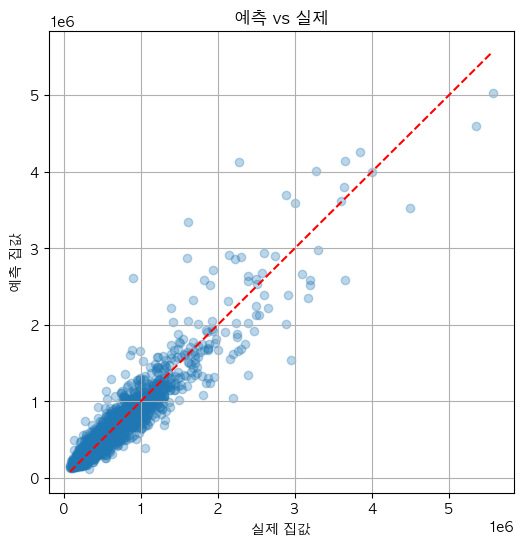

In [22]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import platform

# 한글 폰트 설정
if platform.system() == 'Darwin':  # macOS
    plt.rcParams['font.family'] = 'AppleGothic'
elif platform.system() == 'Windows':  # Windows
    plt.rcParams['font.family'] = 'Malgun Gothic'
else:  # Linux (colab 등)
    plt.rcParams['font.family'] = 'NanumGothic'

# 마이너스 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("실제 집값")
plt.ylabel("예측 집값")
plt.title("예측 vs 실제")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # 기준선
plt.grid()
plt.show()

In [13]:
import numpy as np

# 전처리 전 price 로그 변환
df["price"] = np.log1p(df["price"])  # log(1 + price)

# 모델 훈련 후 예측값 역변환
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)  # log1p의 역변환

136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step


/var/folders/xm/9m5jkr551jxg7scv_lxlytdm0000gn/T/ipykernel_66113/1178186799.py:8: RuntimeWarning: overflow encountered in expm1
  y_pred = np.expm1(y_pred_log)  # log1p의 역변환


In [ ]:
import numpy as np

# 1. 평가 지표 (이미 모델에서 계산된 결과라고 가정)
mae = 74867.29
mse = 17322418176.0

# 2. RMSE 계산
rmse = np.sqrt(mse)

# 3. 실제 집값의 평균 계산 (전처리 전 데이터에서!)
df_raw = pd.read_csv("kc_house_data (1).csv")  # 원본 데이터
price_mean = df_raw["price"].mean()

# 4. 퍼센트 오차율 계산
mae_percent = (mae / price_mean) * 100
rmse_percent = (rmse / price_mean) * 100

# 5. 출력
print(f"MAE: {mae:,.0f} 원 → 평균 집값 대비 {mae_percent:.2f}% 오차")
print(f"RMSE: {rmse:,.0f} 원 → 평균 집값 대비 {rmse_percent:.2f}% 오차")

MAE: 74,867 원 → 평균 집값 대비 13.86% 오차
RMSE: 131,615 원 → 평균 집값 대비 24.37% 오차


In [ ]:
#1. kc_house_data.csv 파일 로드 및 데이터 확인
#2. id 열 제거 (예측에 불필요한 식별자)
#3. date 열을 datetime 타입으로 변환 후 year, month 열 생성
#4. 원래의 date 열은 제거
#5. zipcode 열을 문자열로 변환 후 One-Hot Encoding 수행
#6#. yr_renovated 열을 이진화하여 renovated 열 생성, 원래 열 제거
#7. price(타깃값)에 로그 변환 적용 (log1p) → 고가 주택 분포 안정화
#8. 기본 전처리 함수로 X/y 분리, 스케일링(StandardScaler), 학습/테스트 데이터 분할
#9. MLP 기반 딥러닝 회귀 모델 설계 (은닉층 + Dropout + BatchNormalization)
#10. 모델 학습 (validation_split 포함)
#11. 테스트셋에 대한 MSE/MAE 평가 수행
#12. 예측 결과를 expm1으로 역변환하여 실제 단위로 복원
#13. 예측값 vs 실제값 시각화 → 전체 흐름의 성능 확인
#14. 모델 성능 개선 방향 도출: 로그 변환, 모델 구조 강화, 피처 엔지니어링

In [23]:
df = pd.read_csv("heart (1).csv")  # 1. 데이터 불러오기
df = pd.get_dummies(df, columns=["cp", "restecg", "slope", "thal"])
X_train, X_test, y_train, y_test, scaler = preprocess_data(  # 7. 기본 전처리 (결측치 제거, 분할, 스케일링)
    df,
    label_column="target",
    test_size=0.2,
    scale=True,
    random_state=42
)

In [24]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# 1. 모델 설계
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # 이진 분류용 출력층

# 2. 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 3. 학습
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_split=0.1,
    verbose=1
)

Epoch 1/50


/opt/anaconda3/envs/ai_env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6540 - loss: 0.6234 - val_accuracy: 0.8000 - val_loss: 0.5124
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7319 - loss: 0.5304 - val_accuracy: 0.8000 - val_loss: 0.4550
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8213 - loss: 0.4390 - val_accuracy: 0.8400 - val_loss: 0.4208
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8055 - loss: 0.4669 - val_accuracy: 0.8400 - val_loss: 0.3986
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8497 - loss: 0.3827 - val_accuracy: 0.8400 - val_loss: 0.3817
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8411 - loss: 0.3789 - val_accuracy: 0.8400 - val_loss: 0.3764
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8073 - loss: 0.4257 - val_accuracy: 0.8400 - val_loss: 0.3712
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8219 - loss: 0.3640 - val_accuracy: 0.8800 - val_loss: 0.3625
Ep

In [25]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {acc:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8287 - loss: 0.5999
Test Loss: 0.5318
Test Accuracy: 0.8525


In [26]:
from sklearn.metrics import confusion_matrix, classification_report

# 예측 확률 → 0/1로 변환
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)

# 평가 지표 출력
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[[25  4]
 [ 5 27]]
              precision    recall  f1-score   support

           0       0.83      0.86      0.85        29
           1       0.87      0.84      0.86        32

    accuracy                           0.85        61
   macro avg       0.85      0.85      0.85        61
weighted avg       0.85      0.85      0.85        61



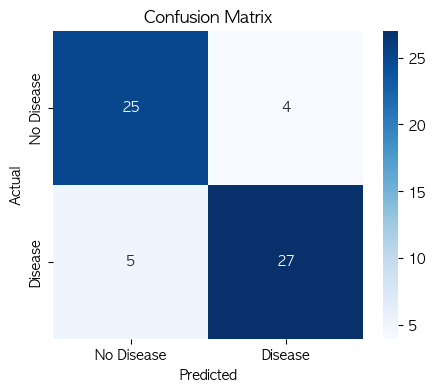

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Disease", "Disease"], yticklabels=["No Disease", "Disease"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
#1. CSV 파일 불러오기 (pd.read_csv)
#2. 필요 시 범주형 열을 One-Hot 인코딩 (get_dummies)
#3. 레이블(y)과 입력 피처(X) 분리
#4. 입력 X에 대해 StandardScaler로 스케일링 적용
#5. train_test_split으로 학습/테스트 데이터 분할 (stratify=y 권장)
#6. Sequential로 MLP 기반 딥러닝 이진 분류 모델 설계
 #   - 출력층: 1개 뉴런 + sigmoid 활성화
#    - 손실 함수: binary_crossentropy
  #  - 평가 지표: accuracy
#7. 모델 학습 (validation_split 포함)
#8. 테스트셋 평가 (evaluate)
#9. 예측 결과 확률 → 0.5 기준으로 0/1 이진화
#10. confusion_matrix로 예측 정확도 분석
#11. classification_report로 precision, recall, f1-score 확인
#12. 혼동 행렬 시각화 (heatmap)
#13. 필요 시 학습곡선, ROC curve, 과적합 여부 시각화